In [12]:

import os, time, copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])


data_dir = "dataset_aug"   # use your augmented dataset

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_clean_dataset = datasets.ImageFolder(os.path.join(data_dir, "val/clean"), transform=val_test_transform)
val_noisy_dataset = datasets.ImageFolder(os.path.join(data_dir, "val/noisy"), transform=val_test_transform)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_clean_loader = DataLoader(val_clean_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_noisy_loader = DataLoader(val_noisy_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

dataloaders = {
    "train": train_loader,
    "val_clean": val_clean_loader,
    "val_noisy": val_noisy_loader,
}

num_classes = len(train_dataset.classes)
print("Classes:", num_classes)

class HybridResNetViT(nn.Module):
    def __init__(self, num_classes, hidden_dim=512, nhead=8, num_layers=4):
        super(HybridResNetViT, self).__init__()

        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        modules = list(resnet.children())[:-2] 
        self.cnn_backbone = nn.Sequential(*modules)
        self.cnn_out_channels = 512 

        self.patch_dim = self.cnn_out_channels
        encoder_layer = TransformerEncoderLayer(d_model=self.patch_dim, nhead=nhead, batch_first=True)
        self.vit_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(self.patch_dim, num_classes)

    def forward(self, x):

        x = self.cnn_backbone(x) 
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  

        x = self.vit_encoder(x)
        x = x.mean(dim=1) 

        return self.fc(x)

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, patience=3, phase="head"):
    since = time.time()
    best_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs} - Phase: {phase}")
        epoch_start = time.time()


        for phase_iter in ["train", "val_clean", "val_noisy"]:
            if phase_iter == "train":
                model.train()
            else:
                model.eval()

            running_loss, running_corrects, total = 0.0, 0, 0
            progress_bar = tqdm(dataloaders[phase_iter], desc=f"{phase_iter} Epoch {epoch+1}", leave=False)

            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase_iter == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase_iter == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total += labels.size(0)

                acc = running_corrects.double() / total
                progress_bar.set_postfix({"Loss": f"{running_loss/total:.4f}",
                                        "Acc": f"{acc:.4f}"})

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total

            print(f"{phase_iter} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase_iter == "val_clean":
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_weights = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1


        epoch_time = time.time() - epoch_start
        print(f"Epoch time: {epoch_time:.1f}s")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break

    total_time = time.time() - since
    print(f"Training complete in {total_time//60:.0f}m {total_time%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    return best_weights

model = HybridResNetViT(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

for param in model.cnn_backbone.parameters():
    param.requires_grad = False
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

best_weights_head = train_model(model, dataloaders, criterion, optimizer, num_epochs=5, patience=3, phase="head")
torch.save(best_weights_head, "best_model_head.pth")

for param in model.cnn_backbone.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_weights = train_model(model, dataloaders, criterion, optimizer, num_epochs=10, patience=3, phase="full")
torch.save(best_weights, "best_model.pth")
print("Training finished, models saved.")


Using device: cpu
Classes: 35

Epoch 1/5 - Phase: head


train Loss: 2.5935 Acc: 0.2810


val_clean Loss: 2.2560 Acc: 0.3639


val_noisy Loss: 2.5476 Acc: 0.2943
Epoch time: 2500.9s

Epoch 2/5 - Phase: head


train Loss: 2.2840 Acc: 0.3571


val_clean Loss: 2.2732 Acc: 0.3486


val_noisy Loss: 2.5186 Acc: 0.3057
Epoch time: 2522.9s

Epoch 3/5 - Phase: head


train Loss: 2.1911 Acc: 0.3796


val_clean Loss: 2.2225 Acc: 0.3596


val_noisy Loss: 2.4603 Acc: 0.3136
Epoch time: 2519.4s

Epoch 4/5 - Phase: head


train Loss: 2.1425 Acc: 0.3935


val_clean Loss: 2.1200 Acc: 0.3911


val_noisy Loss: 2.4187 Acc: 0.3246
Epoch time: 2482.0s

Epoch 5/5 - Phase: head


train Loss: 2.1074 Acc: 0.3981


val_clean Loss: 2.1083 Acc: 0.3918


val_noisy Loss: 2.4434 Acc: 0.3314
Epoch time: 2436.0s
Training complete in 207m 41s
Best val Acc: 0.3918

Epoch 1/10 - Phase: full


train Loss: 0.8912 Acc: 0.7438


val_clean Loss: 0.5532 Acc: 0.8518


val_noisy Loss: 0.6413 Acc: 0.8279
Epoch time: 4225.8s

Epoch 2/10 - Phase: full


train Loss: 0.2859 Acc: 0.9139


val_clean Loss: 0.5354 Acc: 0.8786


val_noisy Loss: 0.6500 Acc: 0.8532
Epoch time: 4225.1s

Epoch 3/10 - Phase: full


train Loss: 0.1814 Acc: 0.9437


val_clean Loss: 0.5459 Acc: 0.8836


val_noisy Loss: 0.7048 Acc: 0.8450
Epoch time: 4246.2s

Epoch 4/10 - Phase: full


train Loss: 0.1303 Acc: 0.9588


val_clean Loss: 0.5675 Acc: 0.8868


val_noisy Loss: 0.6710 Acc: 0.8618
Epoch time: 4209.5s

Epoch 5/10 - Phase: full


train Loss: 0.1064 Acc: 0.9668


val_clean Loss: 0.4900 Acc: 0.9025


val_noisy Loss: 0.5777 Acc: 0.8829
Epoch time: 4233.0s

Epoch 6/10 - Phase: full


train Loss: 0.0858 Acc: 0.9731


val_clean Loss: 0.4735 Acc: 0.8971


val_noisy Loss: 0.5874 Acc: 0.8657
Epoch time: 4259.1s

Epoch 7/10 - Phase: full


train Loss: 0.0759 Acc: 0.9766


val_clean Loss: 0.4990 Acc: 0.8957


val_noisy Loss: 0.6346 Acc: 0.8700
Epoch time: 4773.0s

Epoch 8/10 - Phase: full


train Loss: 0.0685 Acc: 0.9788


val_clean Loss: 0.5365 Acc: 0.8957


val_noisy Loss: 0.6408 Acc: 0.8743
Epoch time: 4516.9s
Early stopping triggered after 3 epochs with no improvement.
Training complete in 578m 8s
Best val Acc: 0.9025
Training finished, models saved.


Using device: cpu
Classes: ['0000168', '0000204', '0000210', '0000295', '0000439', '0000545', '0000662', '0001435', '0001774', '0004266', '0004770', '0004937', '0005527', '0006969', '0010075', '0010736', '0068338', '0136797', '0177896', '0221043', '0221046', '0358316', '0424060', '0515116', '0519456', '0655585', '0688132', '0757855', '0829576', '0913488', '1015262', '1312575', '1374980', '1415323', '1433588']

=== Test Clean Macro Metrics ===
Accuracy: 0.9029
Precision (macro): 0.9081
Recall (macro): 0.9029
F1 Score (macro): 0.9027
ROC-AUC (macro): 0.9962
Avg FAR: 0.1298, Avg FRR: 0.2448, Avg EER: 0.0279


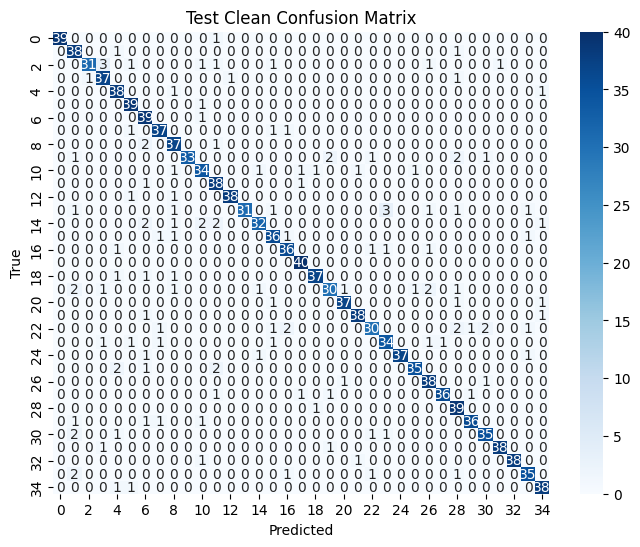

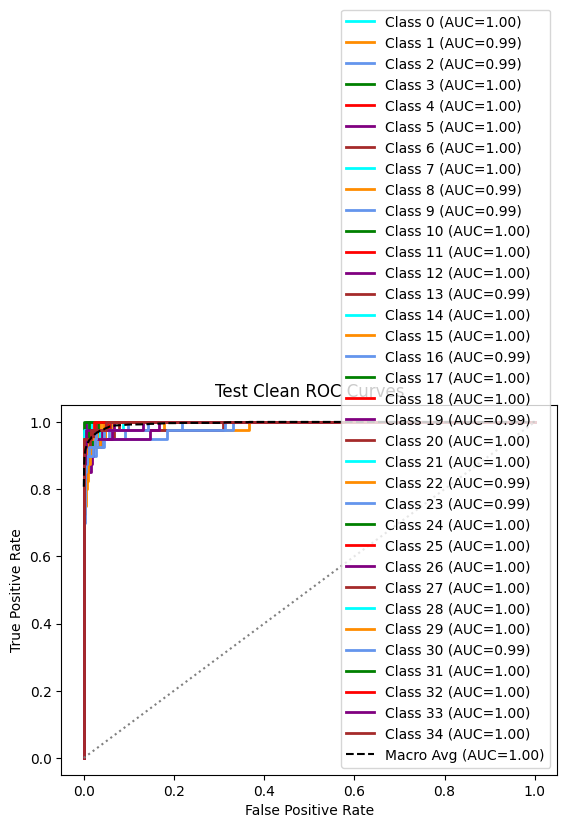


=== Test Noisy Macro Metrics ===
Accuracy: 0.8750
Precision (macro): 0.8827
Recall (macro): 0.8750
F1 Score (macro): 0.8753
ROC-AUC (macro): 0.9946
Avg FAR: 0.0845, Avg FRR: 0.2643, Avg EER: 0.0333


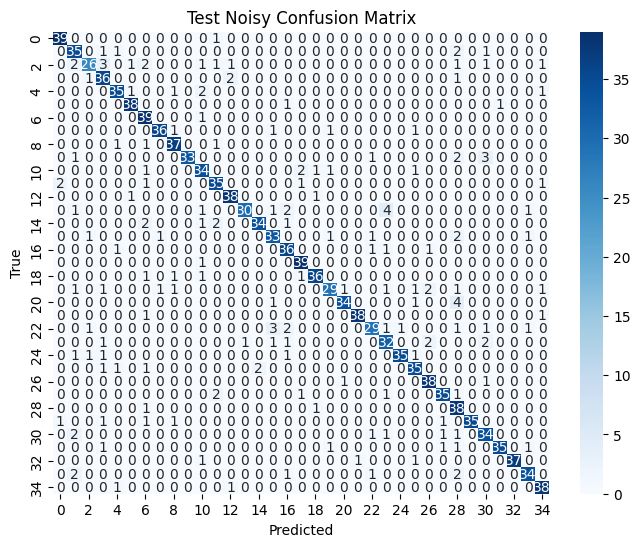

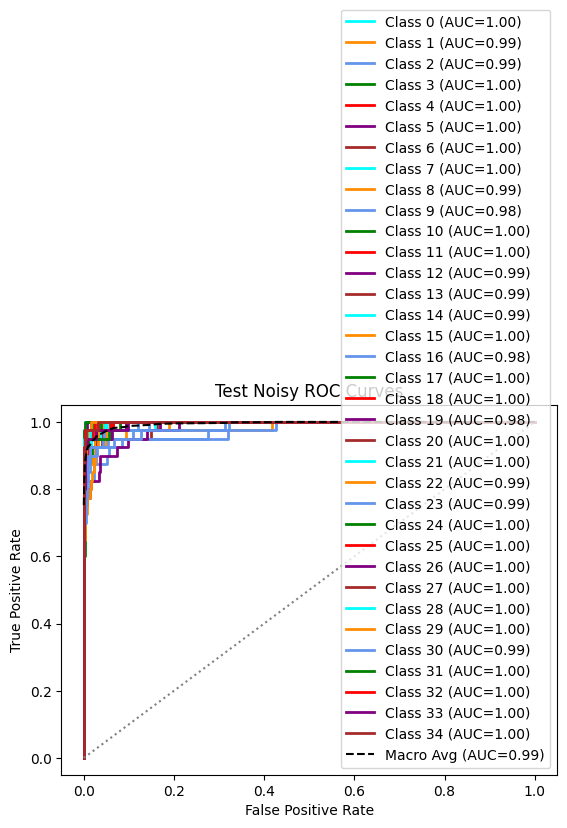


Noise Robustness Score (Accuracy_noisy / Accuracy_clean): 0.9691


In [13]:


import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import cycle



device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)



test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

data_dir = "dataset_aug" 
batch_size = 16

test_clean_dataset = datasets.ImageFolder(os.path.join(data_dir, "test/clean"), transform=test_transform)
test_noisy_dataset = datasets.ImageFolder(os.path.join(data_dir, "test/noisy"), transform=test_transform)

test_clean_loader = DataLoader(test_clean_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_noisy_loader = DataLoader(test_noisy_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

test_loaders = {
    "clean": test_clean_loader,
    "noisy": test_noisy_loader
}

num_classes = len(test_clean_dataset.classes)
print("Classes:", test_clean_dataset.classes)


# Load model

model = HybridResNetViT(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()


# Helper function to compute FAR, FRR, EER

def compute_far_frr_eer(y_true, y_score):
    """
    y_true: binary array (1 for positive, 0 for negative)
    y_score: score/probability for positive class
    Returns: FAR, FRR, EER
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr

    eer_idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
    return fpr.mean(), fnr.mean(), eer



def evaluate_macro(model, dataloader, num_classes, phase_name="Test"):
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = nn.functional.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    preds = np.argmax(all_probs, axis=1)


    accuracy = accuracy_score(all_labels, preds)
    precision = precision_score(all_labels, preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, preds, average='macro', zero_division=0)


    labels_onehot = np.eye(num_classes)[all_labels]
    roc_auc = 0.0
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(labels_onehot[:, i], all_probs[:, i])
        roc_auc += auc(fpr, tpr)
    roc_auc /= num_classes

    far_list, frr_list, eer_list = [], [], []
    for i in range(num_classes):
        far, frr, eer = compute_far_frr_eer(labels_onehot[:, i], all_probs[:, i])
        far_list.append(far)
        frr_list.append(frr)
        eer_list.append(eer)
    avg_far = np.mean(far_list)
    avg_frr = np.mean(frr_list)
    avg_eer = np.mean(eer_list)

    print(f"\n=== {phase_name} Macro Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"ROC-AUC (macro): {roc_auc:.4f}")
    print(f"Avg FAR: {avg_far:.4f}, Avg FRR: {avg_frr:.4f}, Avg EER: {avg_eer:.4f}")

    cm = confusion_matrix(all_labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{phase_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    plt.figure()
    for i, color in zip(range(num_classes), colors):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(labels_onehot[:, i], all_probs[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
        plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=2, label=f"Class {i} (AUC={roc_auc_dict[i]:.2f})")

    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, color='black', linestyle='--', label=f"Macro Avg (AUC={macro_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle=':')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{phase_name} ROC Curves")
    plt.legend(loc="lower right")
    plt.show()
    return accuracy


accuracy_clean = evaluate_macro(model, test_clean_loader, num_classes, phase_name="Test Clean")
accuracy_noisy = evaluate_macro(model, test_noisy_loader, num_classes, phase_name="Test Noisy")

noise_robustness_score = accuracy_noisy / accuracy_clean
print(f"\nNoise Robustness Score (Accuracy_noisy / Accuracy_clean): {noise_robustness_score:.4f}")



In [14]:


import os, time, math, random
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from copy import deepcopy

DATA_DIR = "dataset_aug/test"  
MODEL_PATH = "best_model.pth"
OUT_DIR = "xai_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", DEVICE)

IMG_SIZE = 224
STEPS = 30
VISUALIZE_N = 6
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

test_clean_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "clean"), transform=transform)
test_noisy_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "noisy"), transform=transform)

n_pairs = min(len(test_clean_ds), len(test_noisy_ds))
class_names = test_clean_ds.classes
num_classes = len(class_names)
print(f"Samples (clean, noisy): {len(test_clean_ds)}, {len(test_noisy_ds)}  Paired: {n_pairs}")
print("Classes:", class_names)

class HybridResNetViT(nn.Module):
    def __init__(self, num_classes, hidden_dim=512, nhead=8, num_layers=4):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]
        self.cnn_backbone = nn.Sequential(*modules)
        self.cnn_out_channels = 512

        encoder_layer = nn.TransformerEncoderLayer(d_model=self.cnn_out_channels,
                                                   nhead=min(nhead, self.cnn_out_channels),
                                                   batch_first=True)
        self.vit_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(self.cnn_out_channels, num_classes)

    def forward(self, x):
        x = self.cnn_backbone(x)  
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  
        x = self.vit_encoder(x)
        x = x.mean(dim=1)
        return self.fc(x)


model = HybridResNetViT(num_classes=num_classes).to(DEVICE)
state = torch.load(MODEL_PATH, map_location=DEVICE)
try:
    model.load_state_dict(state)
except RuntimeError:
    print("Warning: strict load failed; loading with strict=False")
    model.load_state_dict(state, strict=False)
model.eval()
print("Model loaded.")


def compute_gradcam(model, input_tensor, target_class, target_layer):
    """
    Returns heatmap resized to (IMG_SIZE, IMG_SIZE) as numpy float32 in [0,1].
    input_tensor: (1,3,H,W) normalized (torch.Tensor)
    target_layer: nn.Module (layer to hook)
    """
    model.zero_grad()
    activation = None
    grad = None

    def forward_hook(module, inp, out):
        nonlocal activation
        activation = out  

    if hasattr(target_layer, "register_full_backward_hook"):
        backward_reg = target_layer.register_full_backward_hook
    else:
        backward_reg = target_layer.register_backward_hook

    def backward_hook(module, grad_in, grad_out):
        nonlocal grad

        grad = grad_out[0]

    fh = target_layer.register_forward_hook(forward_hook)
    bh = backward_reg(backward_hook)


    out = model(input_tensor)  
    if isinstance(out, tuple):
        out = out[0]
    score = out[0, target_class]

    score.backward(retain_graph=False)

    try:
        fh.remove()
    except Exception:
        pass
    try:
        bh.remove()
    except Exception:
        pass

    if activation is None or grad is None:
        raise RuntimeError("Grad-CAM hooks did not record activation/grad.")

    weights = torch.mean(grad, dim=(2,3), keepdim=True) 
    cam_t = torch.sum(weights * activation, dim=1).squeeze(0) 

    cam_t = torch.relu(cam_t)

    cam = cam_t.cpu().detach().numpy()

    cam -= cam.min()
    if cam.max() > 0:
        cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    return cam.astype(np.float32)

target_layer = model.cnn_backbone[-1]
print("Grad-CAM target layer:", target_layer)

mean = np.array([0.485,0.456,0.406])
std  = np.array([0.229,0.224,0.225])

def tensor_to_rgb(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1,2,0)
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img

def overlay_heatmap_on_image(img_tensor, heatmap, alpha=0.5):
    img = tensor_to_rgb(img_tensor)
    heatmap_uint8 = np.uint8(255 * heatmap)
    heat_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)[:, :, ::-1] / 255.0
    overlay = alpha * heat_color + (1 - alpha) * img
    overlay = np.clip(overlay, 0, 1)
    return overlay

def save_overlay(overlay, fname):
    plt.figure(figsize=(3.6,3.6)); plt.axis('off'); plt.imshow(overlay); plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight', pad_inches=0); plt.close()

def compute_faithfulness_pixelwise(model, orig_image_tensor, label, heatmap, device, steps=STEPS):
    """Return insertion_auc, deletion_auc, conf_drop, orig_prob"""
    model.eval()
    # orig prob
    with torch.no_grad():
        inp = orig_image_tensor.unsqueeze(0).to(device)
        out = model(inp)
        prob_orig = torch.softmax(out, dim=1)[0, label].item()

    h, w = heatmap.shape
    flat_idx = np.argsort(-heatmap.flatten())  
    total = h * w

    insertion_probs = []
    deletion_probs = []


    blank = torch.zeros_like(inp).to(device)
    deletion_img = inp.clone().to(device)

    orig_np = inp.cpu().numpy()  

    for step in range(1, steps + 1):
        k = int(total * step / steps)
        if k <= 0:
            k = 1
        chosen = flat_idx[:k]
        coords = np.unravel_index(chosen, (h, w))  

        blank_np = blank.cpu().numpy()
        for c in range(3):
            blank_np[0, c, coords[0], coords[1]] = orig_np[0, c, coords[0], coords[1]]
        blank_tensor = torch.tensor(blank_np, dtype=inp.dtype, device=device)
        with torch.no_grad():
            out_ins = model(blank_tensor)
            p_ins = torch.softmax(out_ins, dim=1)[0, label].item()
            insertion_probs.append(p_ins)

        del_np = deletion_img.cpu().numpy()
        for c in range(3):
            del_np[0, c, coords[0], coords[1]] = 0.0
        deletion_img = torch.tensor(del_np, dtype=inp.dtype, device=device)
        with torch.no_grad():
            out_del = model(deletion_img)
            p_del = torch.softmax(out_del, dim=1)[0, label].item()
            deletion_probs.append(p_del)

    insertion_auc = float(np.trapz(insertion_probs) / steps)
    deletion_auc = float(np.trapz(deletion_probs) / steps)
    conf_drop = float(prob_orig - deletion_probs[-1])

    return insertion_auc, deletion_auc, conf_drop, prob_orig

results = {cls: {"ins": [], "del": [], "drop": [], "orig_probs": []} for cls in class_names}
visual_indices = set(random.sample(range(n_pairs), min(VISUALIZE_N, n_pairs)))

start_time = time.time()
for idx in tqdm(range(n_pairs), desc="XAI Faithfulness", unit="img"):
    img_clean, label_clean = test_clean_ds[idx]
    img_noisy, label_noisy = test_noisy_ds[idx]

    inp = img_clean.unsqueeze(0).to(DEVICE)
    target = int(label_clean)

    try:
        heatmap = compute_gradcam(model, inp, target, target_layer)  
    except Exception as e:

        if idx < 10:
            print(f"Grad-CAM failed at idx {idx} : {e}")
        continue


    try:
        ins_auc, del_auc, conf_drop, orig_prob = compute_faithfulness_pixelwise(
            model, img_clean, target, heatmap, DEVICE, steps=STEPS)
    except Exception as e:
        if idx < 10:
            print(f"Faithfulness failed at idx {idx} : {e}")
        continue

    clsname = class_names[target]
    results[clsname]["ins"].append(ins_auc)
    results[clsname]["del"].append(del_auc)
    results[clsname]["drop"].append(conf_drop)
    results[clsname]["orig_probs"].append(orig_prob)

    if idx in visual_indices:
        overlay_clean = overlay_heatmap_on_image(img_clean, heatmap, alpha=0.5)
        overlay_noisy = overlay_heatmap_on_image(img_noisy, heatmap, alpha=0.5)  
        save_overlay(overlay_clean, os.path.join(OUT_DIR, f"idx{idx}_cls{clsname}_clean.png"))
        save_overlay(overlay_noisy, os.path.join(OUT_DIR, f"idx{idx}_cls{clsname}_noisy.png"))

elapsed = time.time() - start_time
print(f"Done. Time: {elapsed/60:.2f} min")

print("\n=== Faithfulness Summary (per class) ===")
summary_rows = []
for cls in class_names:
    ins = results[cls]["ins"]
    delete = results[cls]["del"]
    drop = results[cls]["drop"]
    origp = results[cls]["orig_probs"]
    if len(ins) == 0:
        print(f"{cls}: no samples processed")
        continue
    print(f"{cls} samples={len(ins)} | insertion={np.mean(ins):.4f} | deletion={np.mean(delete):.4f} | avg_conf_drop={np.mean(drop):.4f} | avg_orig_prob={np.mean(origp):.4f}")
    summary_rows.append((cls, len(ins), np.mean(ins), np.mean(delete), np.mean(drop), np.mean(origp)))


try:
    import csv
    csv_path = os.path.join(OUT_DIR, "faithfulness_summary.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["class","num_samples","insertion_auc","deletion_auc","avg_conf_drop","avg_orig_prob"])
        for row in summary_rows:
            writer.writerow(row)
    print("Saved summary to", csv_path)
except Exception as e:
    print("Could not save CSV:", e)

print("Overlays saved in:", OUT_DIR)


Device: cpu
Samples (clean, noisy): 1400, 1400  Paired: 1400
Classes: ['0000168', '0000204', '0000210', '0000295', '0000439', '0000545', '0000662', '0001435', '0001774', '0004266', '0004770', '0004937', '0005527', '0006969', '0010075', '0010736', '0068338', '0136797', '0177896', '0221043', '0221046', '0358316', '0424060', '0515116', '0519456', '0655585', '0688132', '0757855', '0829576', '0913488', '1015262', '1312575', '1374980', '1415323', '1433588']
Model loaded.
Grad-CAM target layer: Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1

XAI Faithfulness: 100%|██████████| 1400/1400 [1:02:02<00:00,  2.66s/img]

Done. Time: 62.04 min

=== Faithfulness Summary (per class) ===
0000168 samples=40 | insertion=0.3779 | deletion=0.5035 | avg_conf_drop=0.9694 | avg_orig_prob=0.9727
0000204 samples=40 | insertion=0.6052 | deletion=0.1750 | avg_conf_drop=0.9232 | avg_orig_prob=0.9402
0000210 samples=40 | insertion=0.4733 | deletion=0.1706 | avg_conf_drop=0.7372 | avg_orig_prob=0.7484
0000295 samples=40 | insertion=0.5040 | deletion=0.1904 | avg_conf_drop=0.8812 | avg_orig_prob=0.8957
0000439 samples=40 | insertion=0.6916 | deletion=0.3485 | avg_conf_drop=0.9165 | avg_orig_prob=0.9296
0000545 samples=40 | insertion=0.6715 | deletion=0.2904 | avg_conf_drop=0.9604 | avg_orig_prob=0.9761
0000662 samples=40 | insertion=0.5217 | deletion=0.3600 | avg_conf_drop=0.5058 | avg_orig_prob=0.9741
0001435 samples=40 | insertion=0.6069 | deletion=0.1642 | avg_conf_drop=0.8869 | avg_orig_prob=0.9164
0001774 samples=40 | insertion=0.5719 | deletion=0.3728 | avg_conf_drop=0.8955 | avg_orig_prob=0.9228
0004266 samples=40